In [5]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [11]:
name = '30_ieee'
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

In [12]:
alpha = 0.0005
niter = 300000
min_change = 0.005
update_steps = 3

niter_sampling = 200000

In [13]:
class MySamplerNoAC(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, avg_degree, avg_clustering]))
    
betas = torch.tensor([0., 0., 0., 0.], dtype=float)
sampler_no_ac = MySamplerNoAC(backend="cuda")
obs_no_ac = sampler_no_ac.observables(ordmat)
params_no_ac, graphs_no_ac = sampler_no_ac.param_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


  0%|          | 0/300000 [00:00<?, ?it/s]

100%|██████████| 300000/300000 [08:40<00:00, 576.33it/s]

number of accepted steps is:  255335
number of rejected samples:  44665
number of effective updates is:  85111


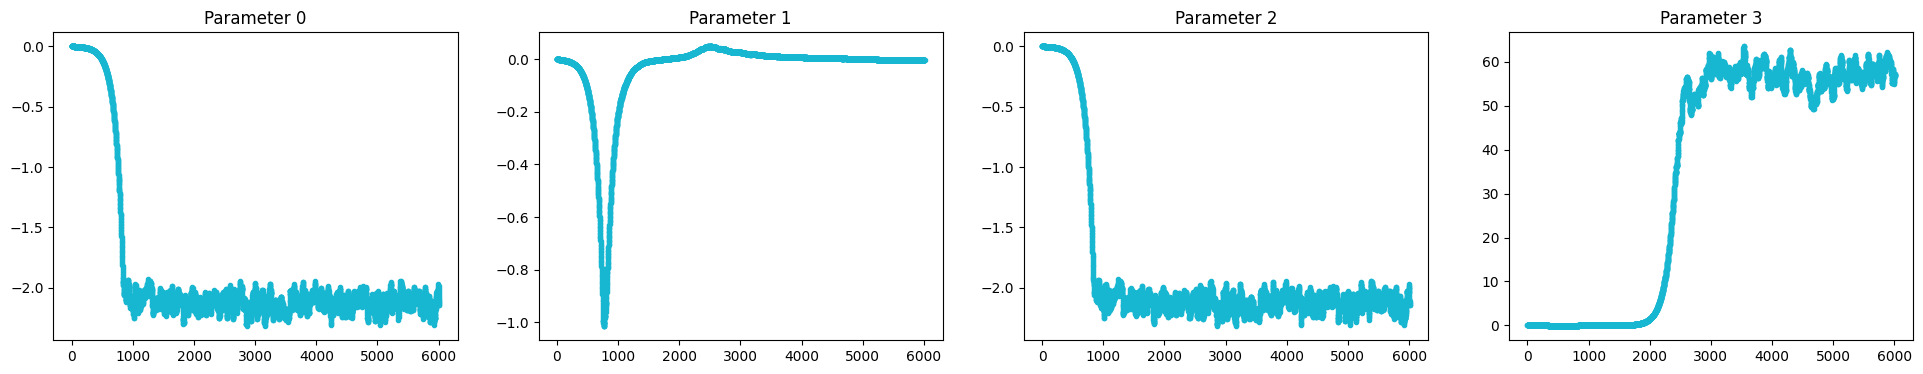

In [14]:
plot_params_iterations(params_no_ac)

In [15]:
params_estimate = torch.stack(params_no_ac[-1000:]).mean(axis = 0)
params_estimate

tensor([-2.1203e+00, -2.7628e-03, -2.1203e+00,  5.7836e+01],
       dtype=torch.float64)

In [16]:

algebraic_conn = torch.tensor([0])

new_params = torch.cat((params_estimate, algebraic_conn), dim=0)
new_params

tensor([-2.1203e+00, -2.7628e-03, -2.1203e+00,  5.7836e+01,  0.0000e+00],
       dtype=torch.float64)

In [17]:
observables_no_ac, graphs_no_ac = sampler_no_ac.sample_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=params_estimate,
                      niter=niter_sampling,
                      save_every=50,
                      burn_in=0.1)

100%|██████████| 200000/200000 [04:22<00:00, 762.72it/s]

number of accepted steps is:  150130
number of rejected samples:  49870
Mean obs:  tensor([39.8870,  6.9978,  2.6591,  0.1443], dtype=torch.float64)


In [18]:
connected_graphs_no_ac, connected_observables_no_ac = connected_graphs(sampler_no_ac, graphs_no_ac, max_components=1)

print(f"Fraction of connected graphs (no ac): {len(connected_graphs_no_ac)} over {len(graphs_no_ac)} sampled")

Fraction of connected graphs (no ac): 340 over 3567 sampled


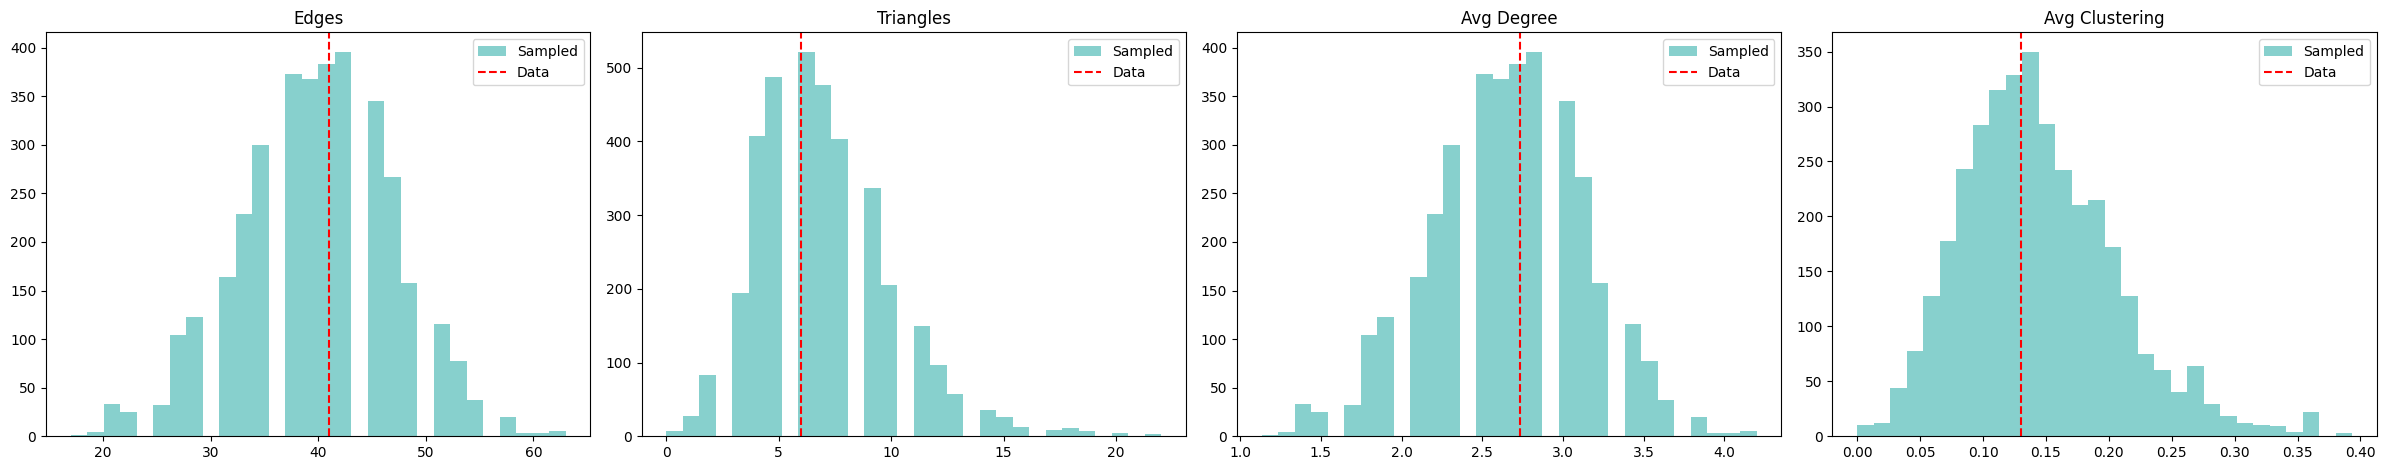

In [20]:
hist_obs_samples(observables_no_ac, obs_no_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering'])

In [22]:
class GWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, avg_degree, avg_clustering, ac]))

ac_sampler = GWGSampler(backend="cuda")


CUDA backend not available falling back to cpu


In [23]:
obs_with_ac = ac_sampler.observables(ordmat)
obs_with_ac

tensor([41.0000,  6.0000,  2.7333,  0.1304,  0.2121], dtype=torch.float64)

In [24]:
mods = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

observable_runs = []
graph_runs = []
number_of_connected = []
number_of_sampled = []

for i in range(len(mods)):
    mod_params = new_params + torch.tensor([0., 0., 0., 0., mods[i]])
    observables_ac, graphs_ac = ac_sampler.sample_run(graph=ordmat,
                          observables=obs_with_ac,
                          params=mod_params,
                          niter=niter_sampling,
                          save_every=50)
                          
    connected_graphs_ac, connected_observables_ac = connected_graphs(ac_sampler, graphs_ac, max_components=1)
    observable_runs.append(observables_ac)
    graph_runs.append(graphs_ac)
    number_of_connected.append(len(connected_graphs_ac))
    number_of_sampled.append(len(graphs_ac))

    print(f"Mod: {mods[i]} - Fraction of connected graphs: {len(connected_graphs_ac)} over {len(graphs_ac)} sampled")

100%|██████████| 200000/200000 [05:31<00:00, 602.78it/s]


number of accepted steps is:  125090
number of rejected samples:  74910
Mean obs:  tensor([3.2103e+01, 5.4237e+00, 2.1402e+00, 2.3616e-01, 2.0163e-02],
       dtype=torch.float64)
Mod: 0 - Fraction of connected graphs: 296 over 3925 sampled


100%|██████████| 200000/200000 [05:48<00:00, 573.24it/s]


number of accepted steps is:  147471
number of rejected samples:  52529
Mean obs:  tensor([3.9328e+01, 6.9122e+00, 2.6219e+00, 1.4943e-01, 2.5817e-02],
       dtype=torch.float64)
Mod: 0.0001 - Fraction of connected graphs: 371 over 3998 sampled


100%|██████████| 200000/200000 [05:45<00:00, 578.34it/s]


number of accepted steps is:  146949
number of rejected samples:  53051
Mean obs:  tensor([3.9037e+01, 6.8424e+00, 2.6024e+00, 1.5238e-01, 2.4365e-02],
       dtype=torch.float64)
Mod: 0.001 - Fraction of connected graphs: 352 over 3954 sampled


100%|██████████| 200000/200000 [05:51<00:00, 569.21it/s]


number of accepted steps is:  148511
number of rejected samples:  51489
Mean obs:  tensor([3.9695e+01, 6.9536e+00, 2.6464e+00, 1.4880e-01, 2.6843e-02],
       dtype=torch.float64)
Mod: 0.01 - Fraction of connected graphs: 391 over 4031 sampled


100%|██████████| 200000/200000 [05:50<00:00, 570.43it/s]


number of accepted steps is:  147238
number of rejected samples:  52762
Mean obs:  tensor([3.8987e+01, 6.8428e+00, 2.5991e+00, 1.5030e-01, 2.2444e-02],
       dtype=torch.float64)
Mod: 0.1 - Fraction of connected graphs: 355 over 4013 sampled


100%|██████████| 200000/200000 [05:48<00:00, 573.63it/s]


number of accepted steps is:  146531
number of rejected samples:  53469
Mean obs:  tensor([3.9622e+01, 6.9539e+00, 2.6415e+00, 1.4836e-01, 3.5976e-02],
       dtype=torch.float64)
Mod: 1 - Fraction of connected graphs: 507 over 4079 sampled


100%|██████████| 200000/200000 [05:17<00:00, 629.68it/s]


number of accepted steps is:  81310
number of rejected samples:  118690
Mean obs:  tensor([54.5470, 10.3063,  3.6365,  0.1065,  0.5168], dtype=torch.float64)
Mod: 10 - Fraction of connected graphs: 3498 over 3823 sampled


100%|██████████| 200000/200000 [06:00<00:00, 555.08it/s]


number of accepted steps is:  1
number of rejected samples:  199999
Mean obs:  tensor([41.0000,  6.0000,  2.7333,  0.1304,  0.2121], dtype=torch.float64)
Mod: 100 - Fraction of connected graphs: 162894 over 162894 sampled


In [50]:
mods, number_of_connected, number_of_sampled

([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 [471, 281, 222, 400, 362, 548, 3369, 2004],
 [3984, 3870, 4024, 3999, 4033, 4095, 3937, 2004])

Text(0, 0.5, 'Number of Graphs')

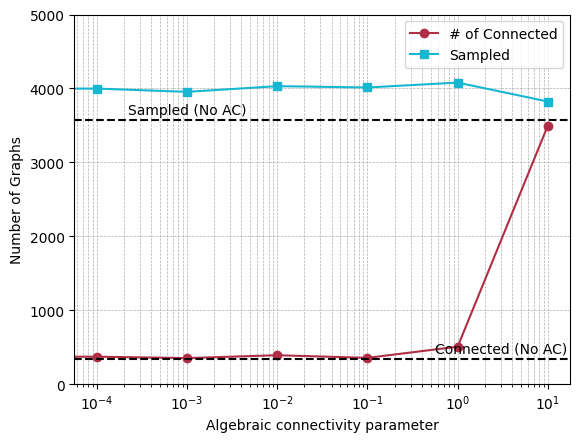

In [27]:
plt.plot(mods[:-1], number_of_connected[:-1], marker="o", label="# of Connected", color='#af2e45')
plt.plot(mods[:-1], number_of_sampled[:-1], marker="s", label="Sampled", color='#17B6D1')
plt.ylim(0, 5000)
plt.axhline(y=len(connected_graphs_no_ac), color='black', linestyle='--')
plt.axhline(y=len(graphs_no_ac), color='black', linestyle='--')
plt.text(
    x=10e-4, y=len(graphs_no_ac)+50,
    s="Sampled (No AC)", color="black",
    ha="center", va="bottom"
)
plt.text(
    x=3, y=len(connected_graphs_no_ac)+50,
    s="Connected (No AC)", color="black",
    ha="center", va="bottom"
)
plt.legend()

plt.xscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlabel("Algebraic connectivity parameter")
plt.ylabel("Number of Graphs")

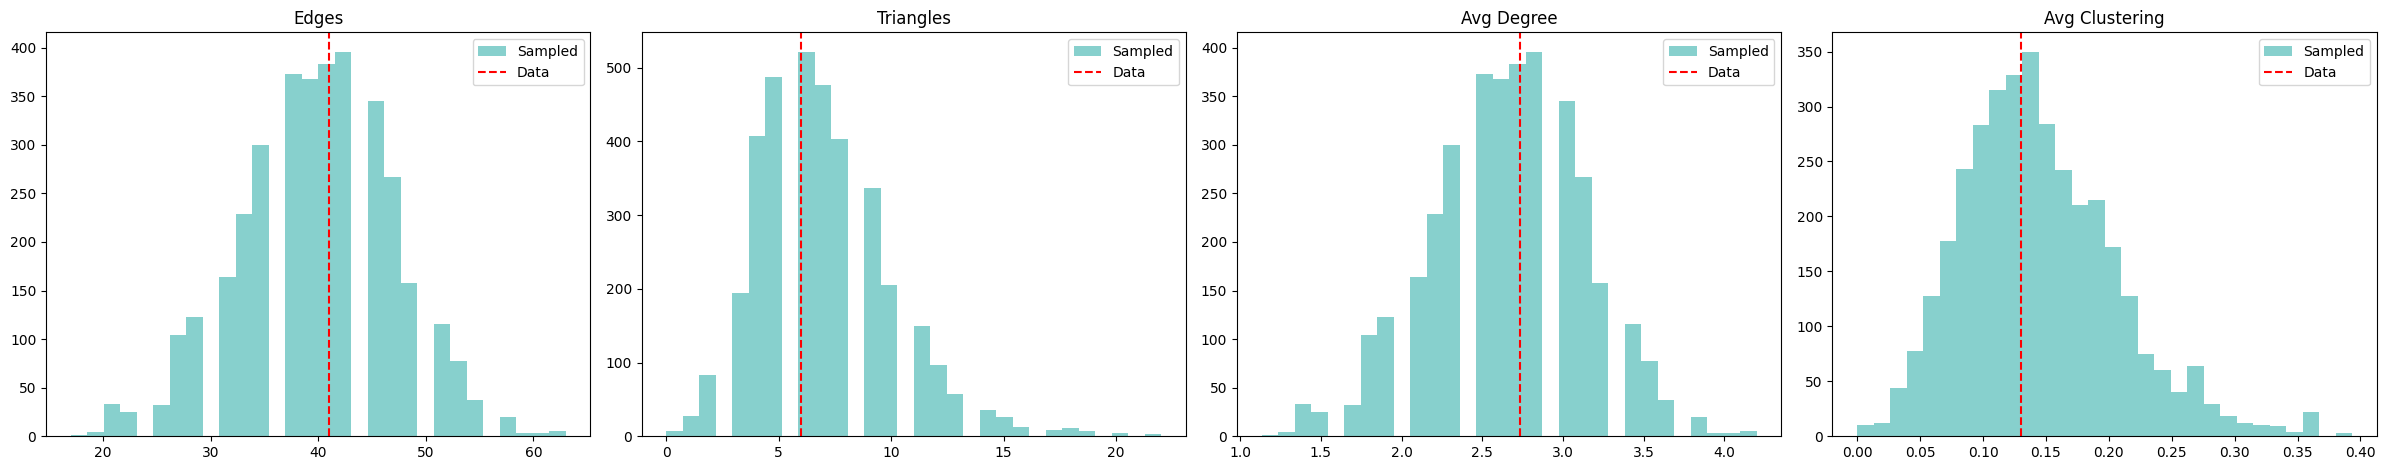

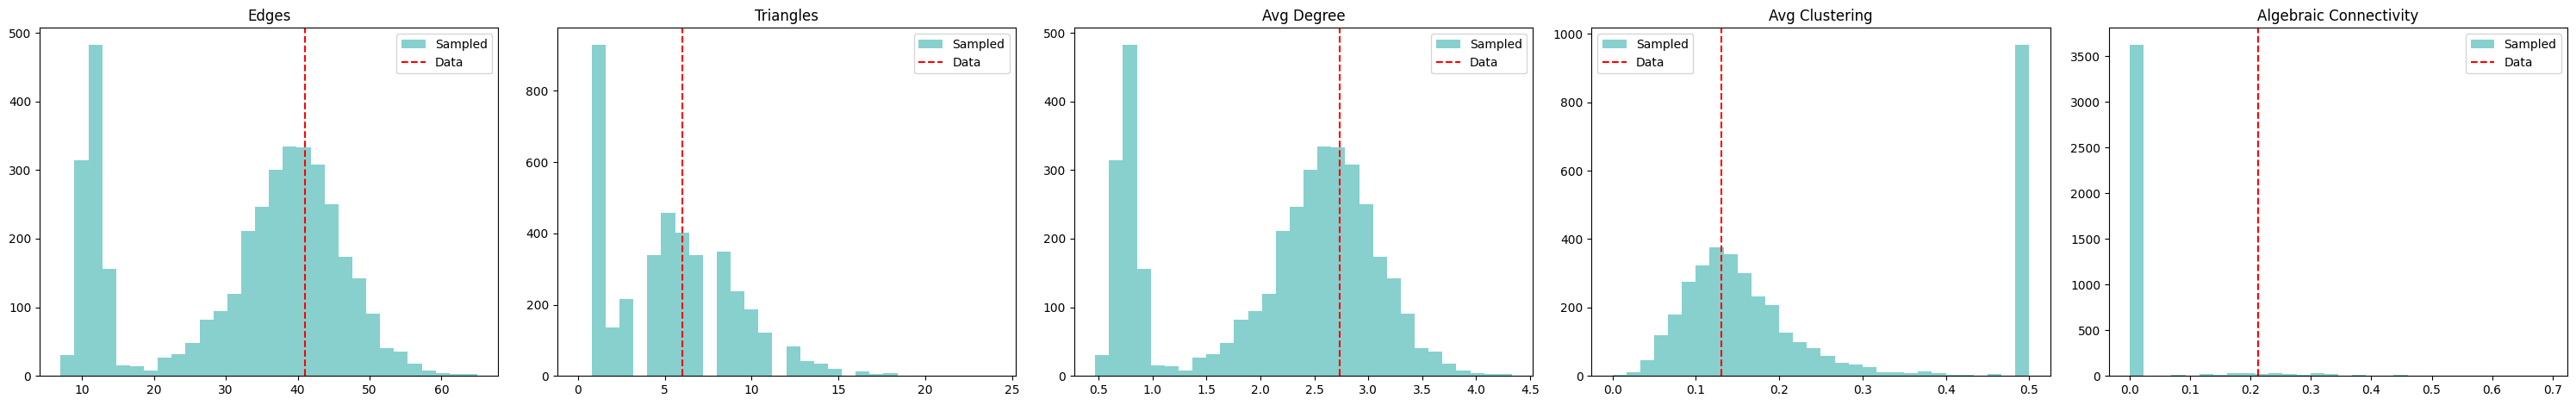

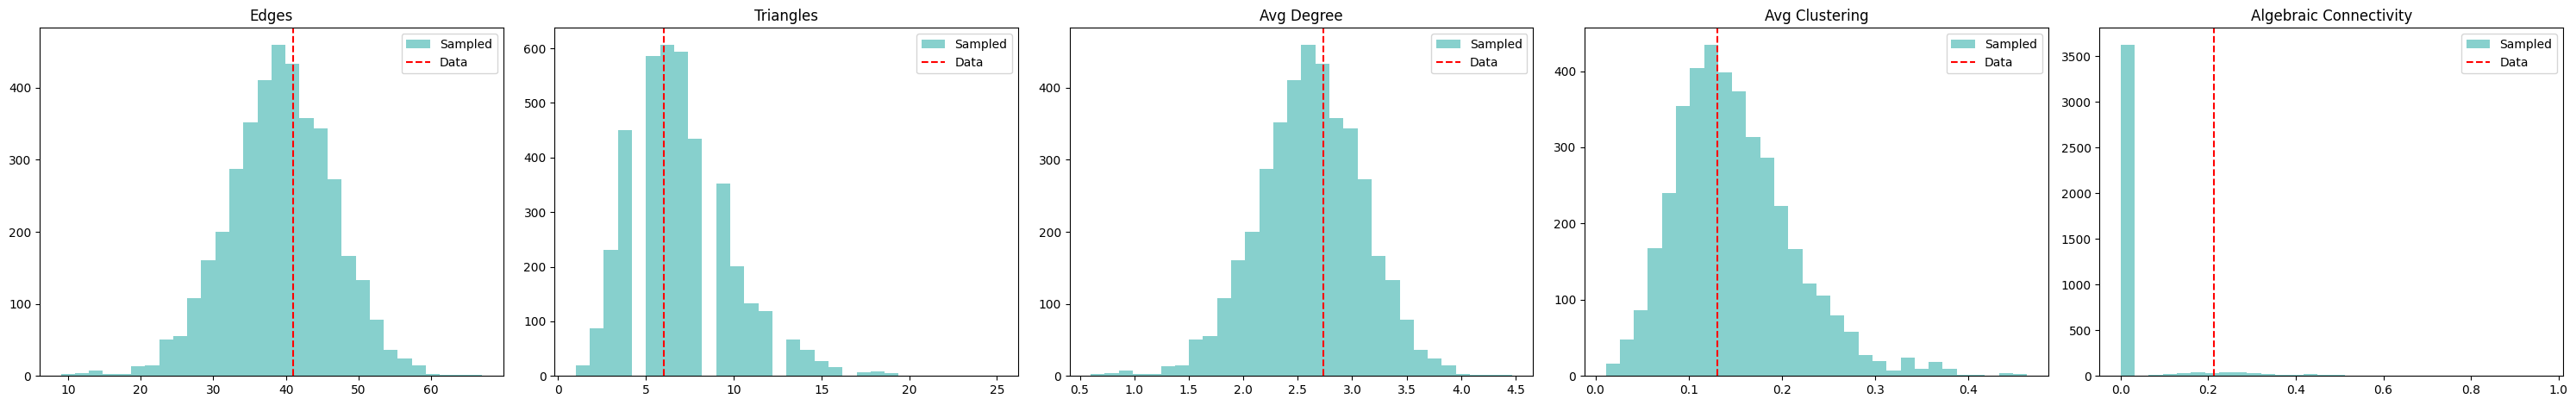

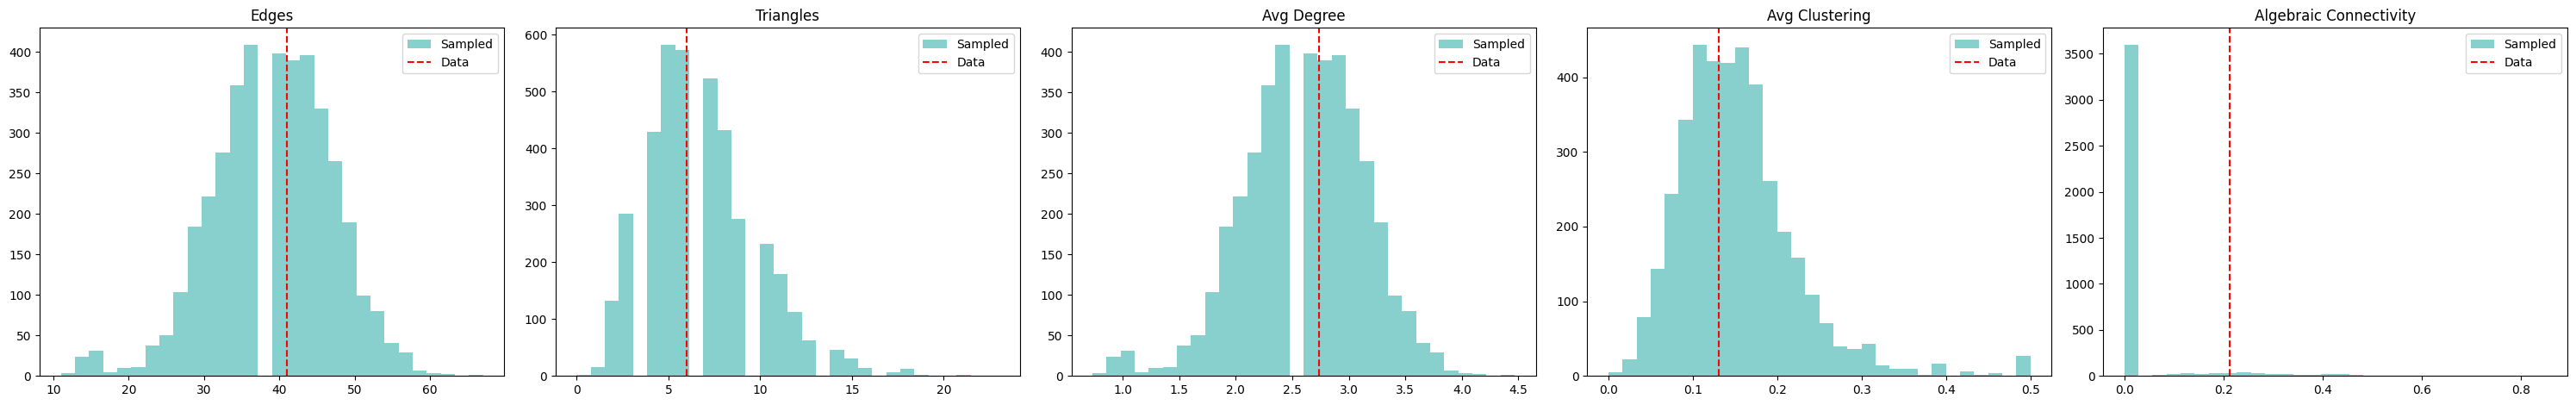

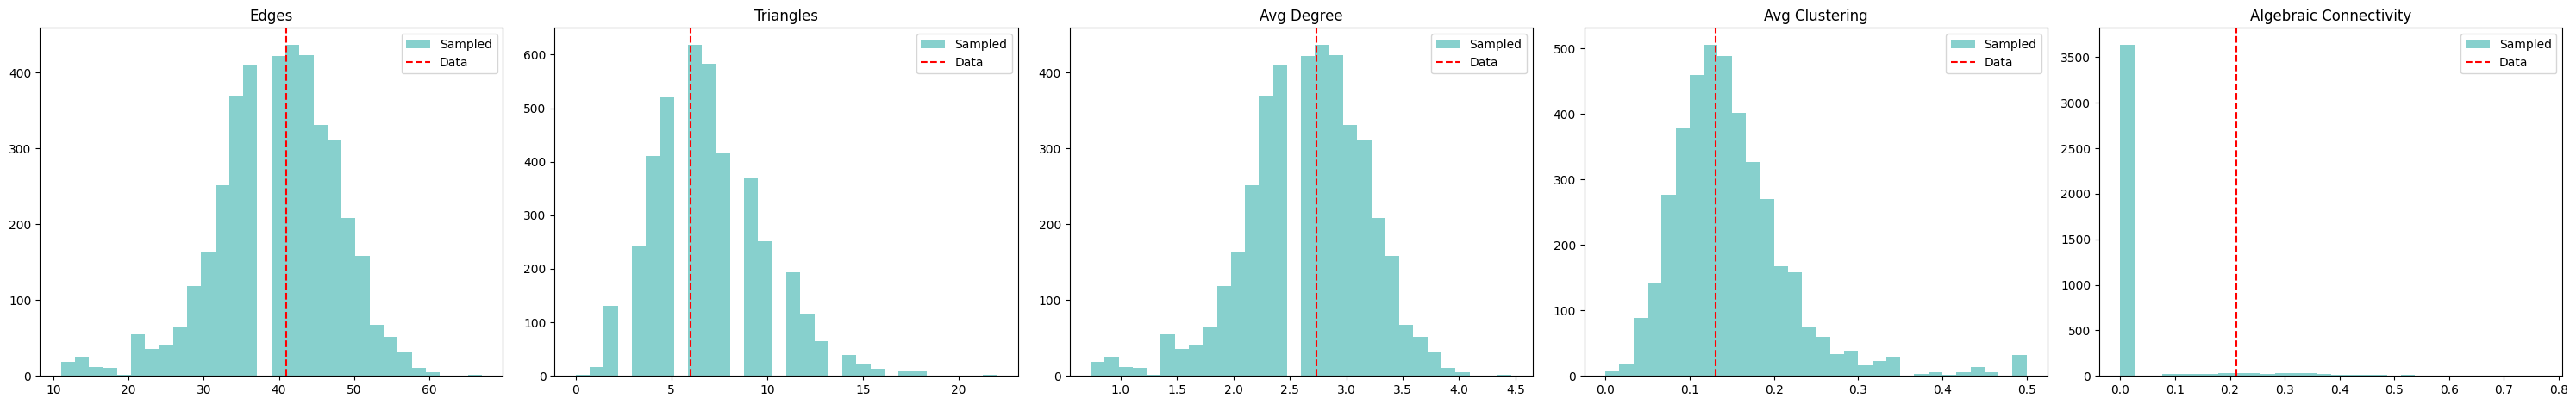

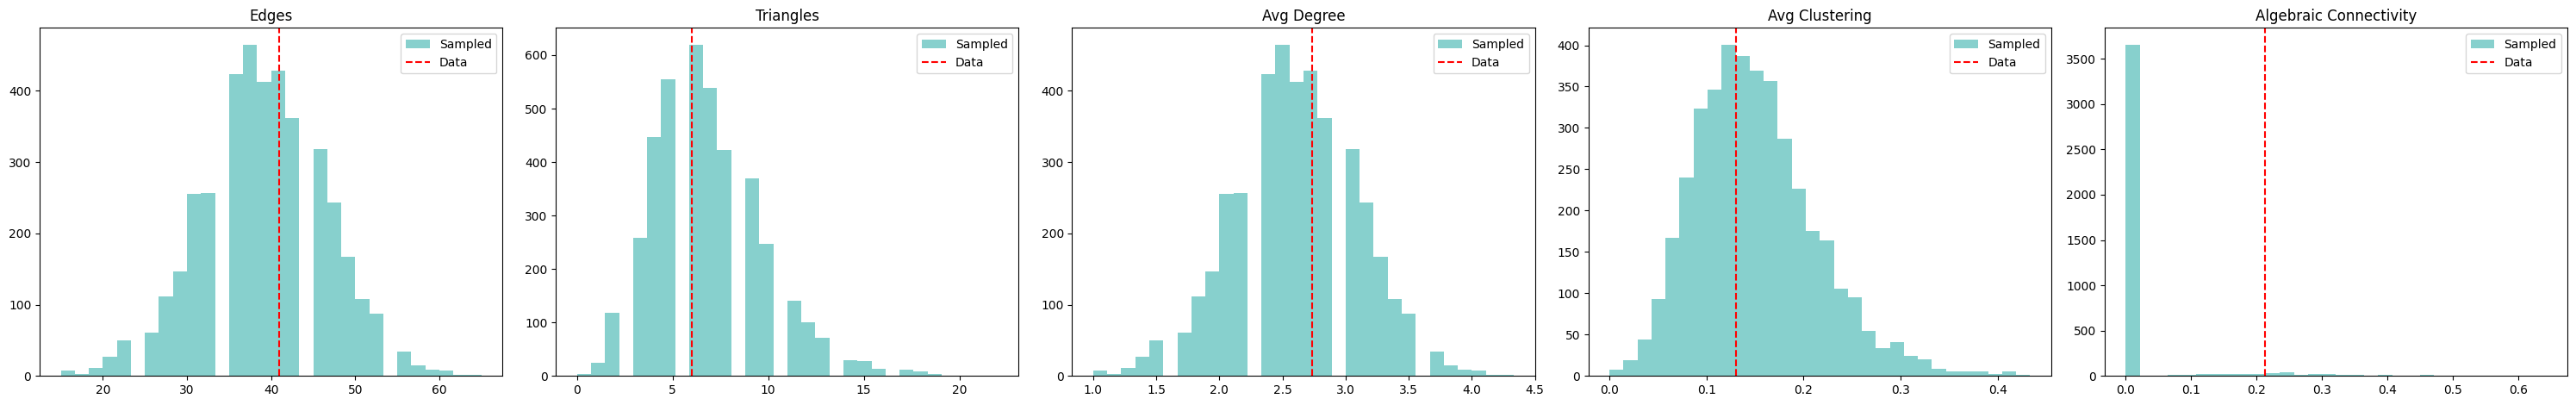

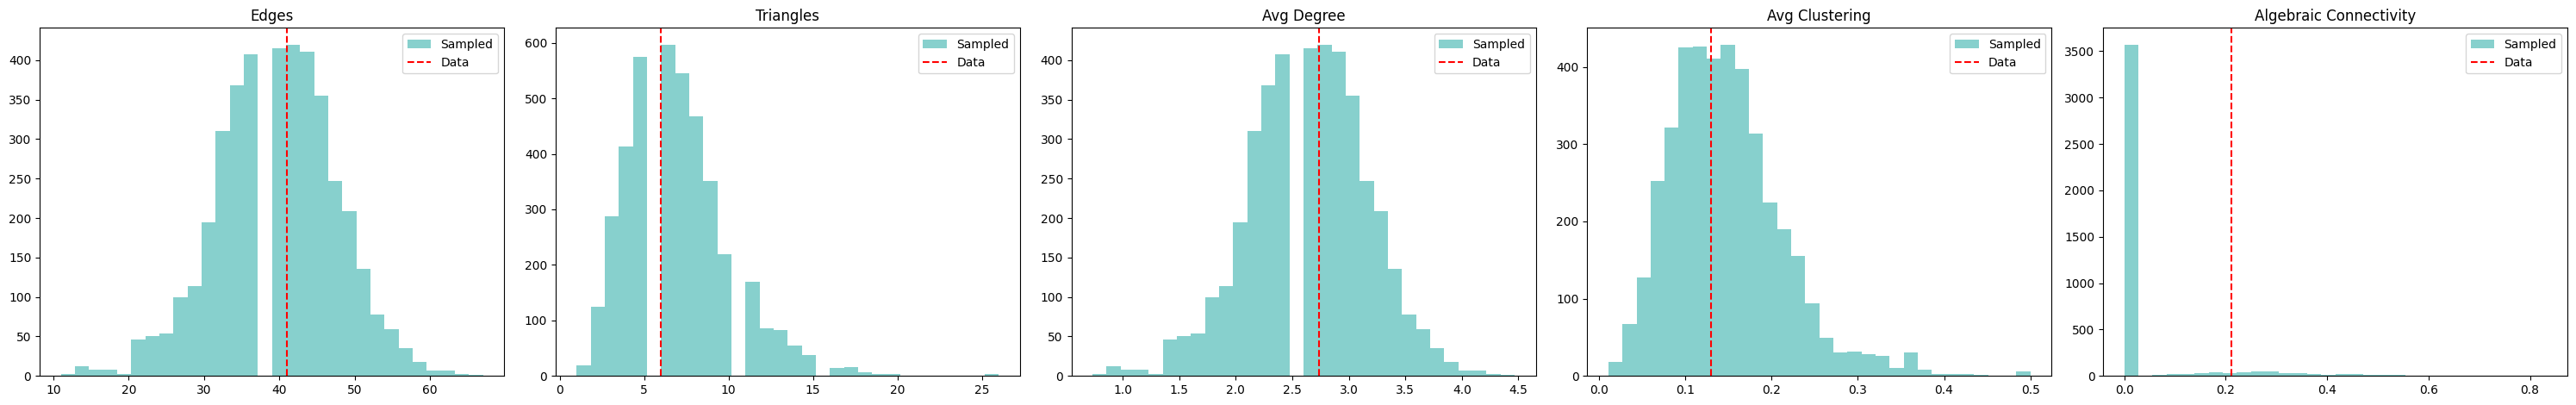

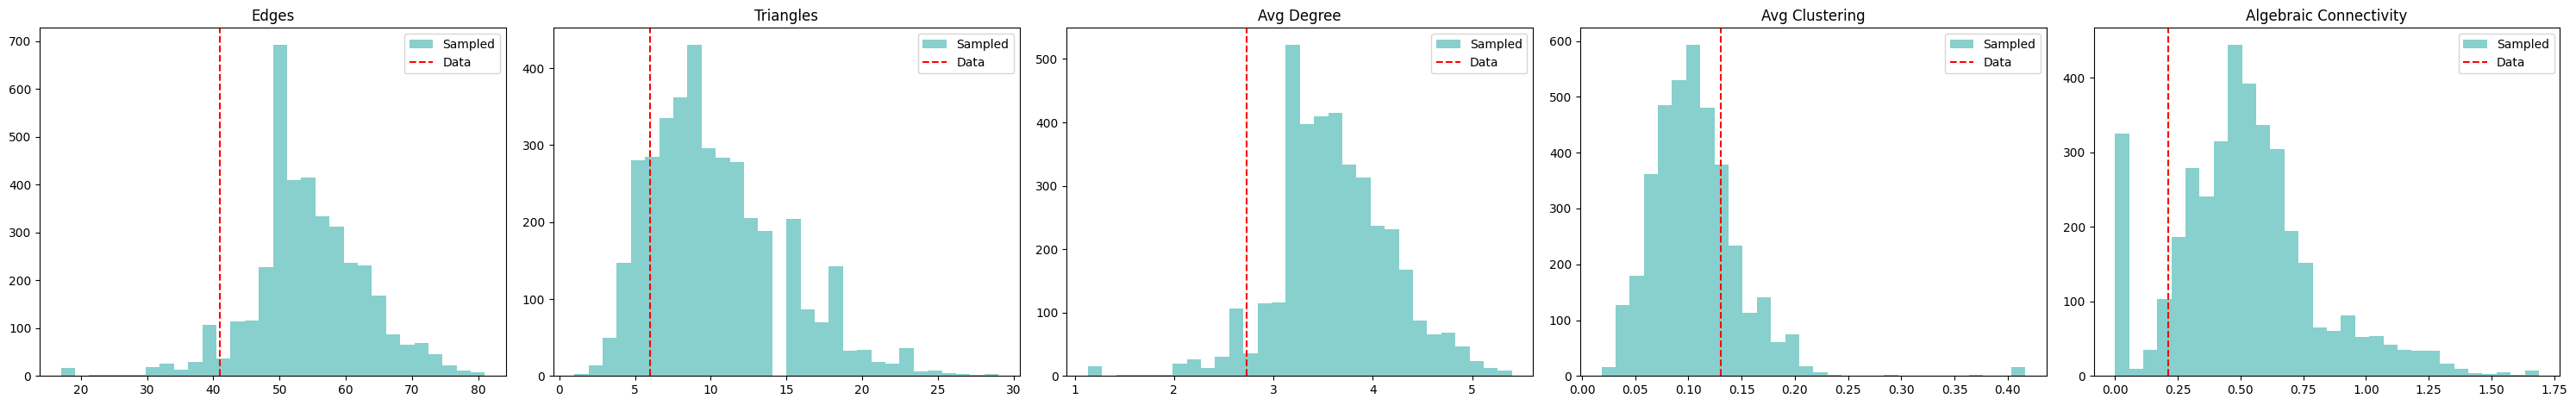

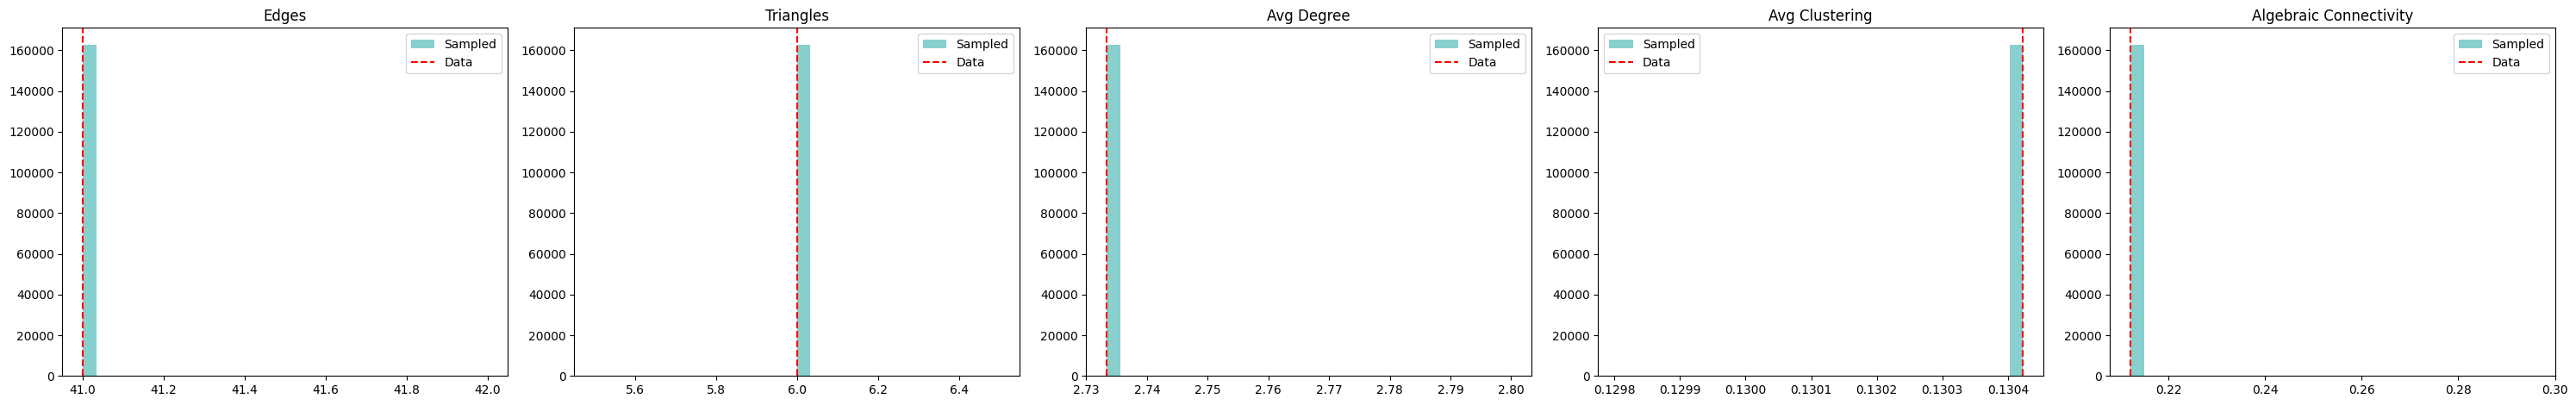

In [30]:
hist_obs_samples(observables_no_ac, obs_no_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering'])
for i in range(len(mods)):
    hist_obs_samples(observable_runs[i], obs_with_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering', 'Algebraic Connectivity'])

In [45]:
observable_runs_means = []
observable_runs_stds = []
for i in range(len(mods)):
    observable_runs_means.append(torch.stack(observable_runs[i]).mean(axis=0))
    observable_runs_stds.append(torch.stack(observable_runs[i]).std(axis=0))

print(observable_runs_means[:-1])

[tensor([3.2103e+01, 5.4237e+00, 2.1402e+00, 2.3616e-01, 2.0163e-02],
       dtype=torch.float64), tensor([3.9328e+01, 6.9122e+00, 2.6219e+00, 1.4943e-01, 2.5817e-02],
       dtype=torch.float64), tensor([3.9037e+01, 6.8424e+00, 2.6024e+00, 1.5238e-01, 2.4365e-02],
       dtype=torch.float64), tensor([3.9695e+01, 6.9536e+00, 2.6464e+00, 1.4880e-01, 2.6843e-02],
       dtype=torch.float64), tensor([3.8987e+01, 6.8428e+00, 2.5991e+00, 1.5030e-01, 2.2444e-02],
       dtype=torch.float64), tensor([3.9622e+01, 6.9539e+00, 2.6415e+00, 1.4836e-01, 3.5976e-02],
       dtype=torch.float64), tensor([54.5470, 10.3063,  3.6365,  0.1065,  0.5168], dtype=torch.float64)]


In [39]:
tensorm = torch.stack(observable_runs_means[:-1])
tensorm

tensor([[3.2103e+01, 5.4237e+00, 2.1402e+00, 2.3616e-01, 2.0163e-02],
        [3.9328e+01, 6.9122e+00, 2.6219e+00, 1.4943e-01, 2.5817e-02],
        [3.9037e+01, 6.8424e+00, 2.6024e+00, 1.5238e-01, 2.4365e-02],
        [3.9695e+01, 6.9536e+00, 2.6464e+00, 1.4880e-01, 2.6843e-02],
        [3.8987e+01, 6.8428e+00, 2.5991e+00, 1.5030e-01, 2.2444e-02],
        [3.9622e+01, 6.9539e+00, 2.6415e+00, 1.4836e-01, 3.5976e-02],
        [5.4547e+01, 1.0306e+01, 3.6365e+00, 1.0651e-01, 5.1678e-01]],
       dtype=torch.float64)

In [46]:
tensorstd = torch.stack(observable_runs_stds[:-1])
tensorstd

tensor([[14.1325,  3.6051,  0.9422,  0.1612,  0.0779],
        [ 7.5037,  2.8948,  0.5002,  0.0634,  0.0900],
        [ 7.8344,  2.9913,  0.5223,  0.0693,  0.0872],
        [ 7.9149,  2.8901,  0.5277,  0.0706,  0.0917],
        [ 7.3318,  2.9054,  0.4888,  0.0622,  0.0804],
        [ 7.8223,  3.0777,  0.5215,  0.0658,  0.1068],
        [ 8.6729,  4.4115,  0.5782,  0.0426,  0.2892]], dtype=torch.float64)

/tmp/ipykernel_30277/2322978641.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


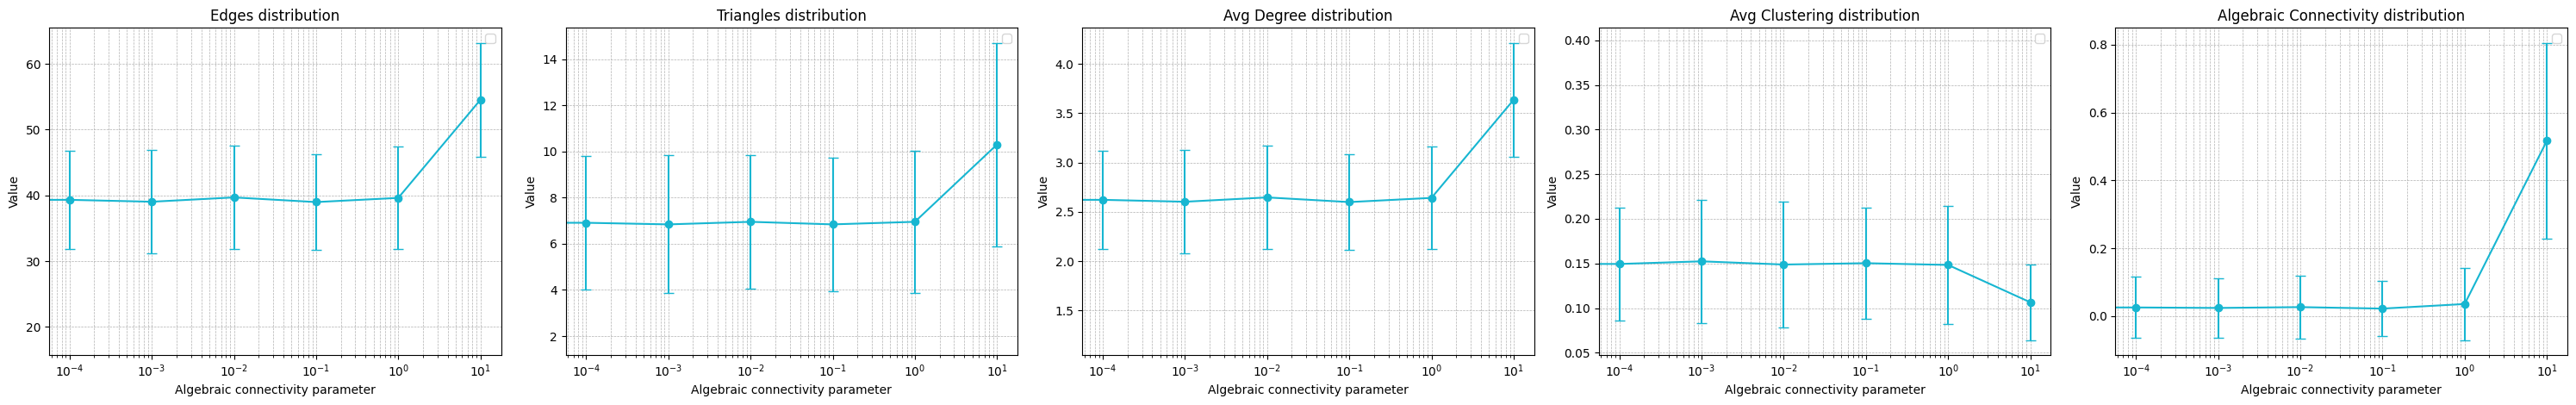

In [50]:

w = 10
h = 8
scale = 0.6
n_obs = len(observable_runs_means[0])
figsize = (n_obs * w * scale, h * scale)
fig, axes = plt.subplots(1, n_obs, figsize=figsize, squeeze=False)

obs_labels = ['Edges distribution', 'Triangles distribution', 'Avg Degree distribution', 'Avg Clustering distribution', 'Algebraic Connectivity distribution']

for p in range(n_obs):
    ax = axes[0, p]
    ys = tensorm[:, p]
    yerr = tensorstd[:, p]
    ax.errorbar(mods[:-1], ys, yerr=yerr, fmt="o-", capsize=4, color='#17B6D1')
    ax.set_xlabel("Algebraic connectivity parameter")
    ax.set_ylabel("Value")
    ax.set_xscale("log")
    ax.grid(True, which="both", ls="--", lw=0.5)
    ax.set_title(f'{obs_labels[p]}')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [ ]:
def hist_obs_samples(observables_samples: list, observable_data: torch.Tensor, w = 10, h = 8, scale = 0.6, color = "#11a39c", bins = 30, obs_labels = None):
    num_obs = observables_samples[0].shape[0]
    figsize = (num_obs * w * scale, h * scale)
    
    samples_np = torch.stack(observables_samples).cpu().numpy()
    data_np = observable_data.cpu().numpy()
    
    fig, axes = plt.subplots(1, num_obs, figsize=figsize, squeeze=False)
    
    for p in range(num_obs):
        ax = axes[0, p]

        obs_samples = samples_np[:, p]
        ax.hist(obs_samples, bins=bins, alpha=0.5, label='Sampled', color=color)

        if data_np.ndim == 1 or data_np.shape[0] < 2:
            ax.axvline(data_np[p], color='r', linestyle='--', label='Data')
        else:
            ax.hist(data_np[:, p], bins=bins, alpha=0.5, label='Data')
        if obs_labels is not None:
            ax.set_title(f'{obs_labels[p]}')
        else:
            ax.set_title(f'Observable {p}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()